# Data cleaning 3: outliers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
import seaborn as sns
from sqlalchemy import create_engine

from config import usr, pwd, url, port, db

%matplotlib inline

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
study_columns = ['PRIMARY_KEY', 'STATE', 'YEAR', 'TOTAL_REVENUE', 'TOTAL_EXPENDITURE']

In [6]:
df = df.loc[:, study_columns].copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 5 columns):
PRIMARY_KEY          1492 non-null object
STATE                1492 non-null object
YEAR                 1492 non-null int64
TOTAL_REVENUE        1280 non-null float64
TOTAL_EXPENDITURE    1280 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 58.4+ KB


## Interpolate outliers

In [8]:
def find_na_columns(df):
    na_fractions = (df.isnull().sum()/df.isnull().count())*100
    return na_fractions[na_fractions != 0].index.tolist()

In [9]:
def apply_interpolation(df):
    df_interpolated = df.copy()
    na_columns = find_na_columns(df_interpolated)
    
    for column in na_columns:
        for year in df_interpolated['YEAR'].unique():
            df_interpolated[column].interpolate(inplace=True)
        
    return df_interpolated

In [10]:
df_clean = apply_interpolation(df)

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 5 columns):
PRIMARY_KEY          1492 non-null object
STATE                1492 non-null object
YEAR                 1492 non-null int64
TOTAL_REVENUE        1492 non-null float64
TOTAL_EXPENDITURE    1492 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 58.4+ KB


## Total Revenue and Total Expenditures
### Outlier methods

In [12]:
thresholds = {
    'tukey': 1.5,
    'winsor_lower': 0.05,
    'winsor_upper': 0.05
}

In [13]:
def log_transform(df, column):
    df[f'log_{column}'] = np.log(df[column])
    return df

In [14]:
def sqrt_transform(df, column):
    df[f'sqrt_{column}'] = np.sqrt(df[column])
    return df

In [15]:
def apply_tukey(df, column, thresh=1.5):
    q75, q25 = np.percentile(df[column], [75, 25])
    iqr = q75 - q25
    min_value = q25 - thresh*iqr
    max_value = q75 + thresh*iqr
    df[f'tukey_{column}'] = df[column].apply(lambda x: np.min([x, max_value]))
    df[f'tukey_{column}'] = df[f'tukey_{column}'].apply(lambda x: np.max([x, min_value]))
    return df

In [16]:
def apply_winsorize(df, column, lower_thresh=0.05, upper_thresh=0.05):
    df[f'winsor_{column}'] = winsorize(df[column], (lower_thresh, upper_thresh)).data
    return df

In [17]:
def correct_outliers(df, column_list):
    for column in column_list:
        # Tukey
        df = apply_tukey(df, column, thresh=thresholds['tukey'])
    
        # Winsorize
        df = apply_winsorize(df, column, 
                             lower_thresh=thresholds['winsor_lower'], 
                             upper_thresh=thresholds['winsor_upper'])
        
    return df

In [18]:
def stack_dataframe(df, column_list):
    df_stacked = df.loc[:, column_list].stack().copy()
    df_stacked.index = df_stacked.index.droplevel()
    df_stacked = df_stacked.reset_index().copy()
    df_stacked = df_stacked.rename(columns={'index': 'label', 0: 'value'})
    df_stacked = df_stacked.sort_values(by='label')
    df_stacked.index = np.arange(len(df_stacked))
    return df_stacked

In [19]:
def look_for_outliers(df, column_list):
    
    if len(column_list) > 1:
        df_stacked = stack_dataframe(df, column_list)
        sns.catplot(x='label', y='value', data=df_stacked, height=6, aspect=12/6, kind='box')
        plt.show()
    else:
        sns.catplot(y=column_list[0], data=df_clean, height=6, aspect=12/6, kind='box')
        plt.show()

## Look for outliers
### Original

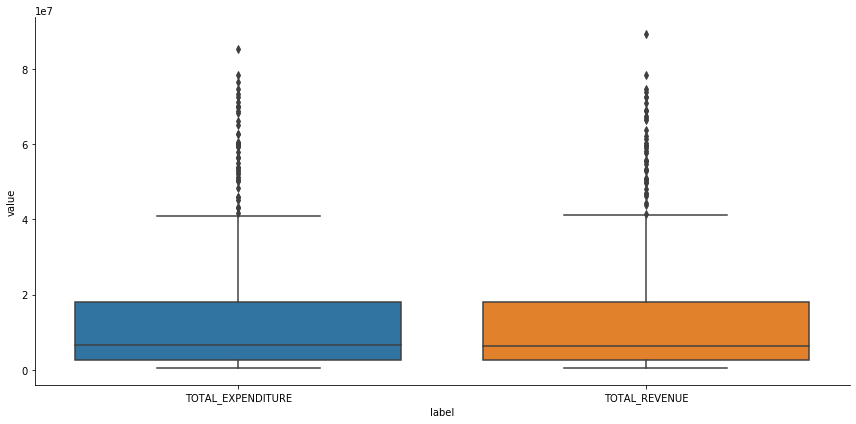

In [20]:
column_list = ['TOTAL_REVENUE', 'TOTAL_EXPENDITURE']
look_for_outliers(df_clean, column_list)

### Log Transformed

In [21]:
df_clean = log_transform(df_clean, 'TOTAL_REVENUE')
df_clean = log_transform(df_clean, 'TOTAL_EXPENDITURE')

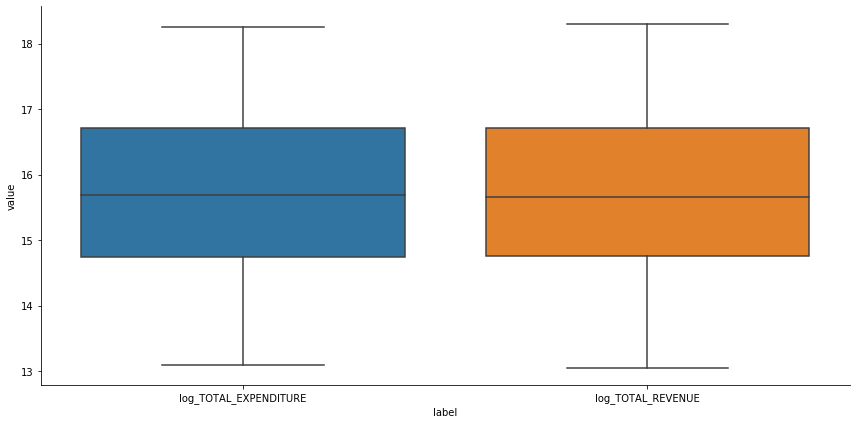

In [22]:
column_list = ['log_TOTAL_REVENUE', 'log_TOTAL_EXPENDITURE']
look_for_outliers(df_clean, column_list)

### Square-root transformed

In [23]:
df_clean = sqrt_transform(df_clean, 'TOTAL_REVENUE')
df_clean = sqrt_transform(df_clean, 'TOTAL_EXPENDITURE')

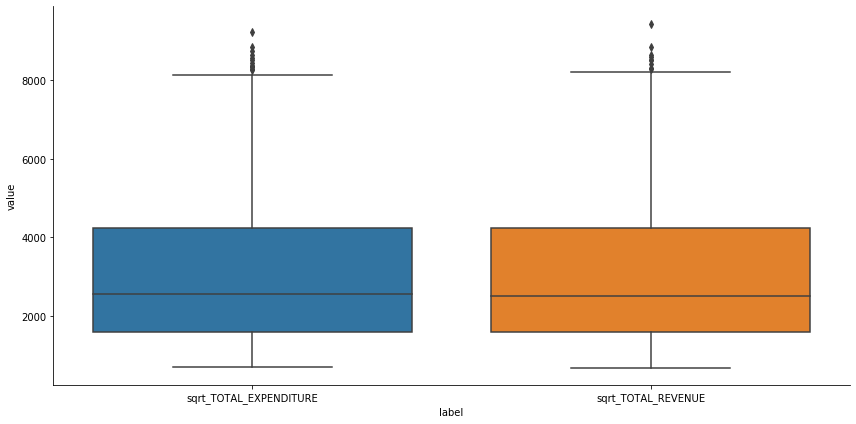

In [24]:
column_list = ['sqrt_TOTAL_REVENUE', 'sqrt_TOTAL_EXPENDITURE']
look_for_outliers(df_clean, column_list)

## Correcting outliers
### Original - Using Tukey method

In [25]:
column_list = ['TOTAL_REVENUE', 'TOTAL_EXPENDITURE']
df_clean = correct_outliers(df_clean, column_list)

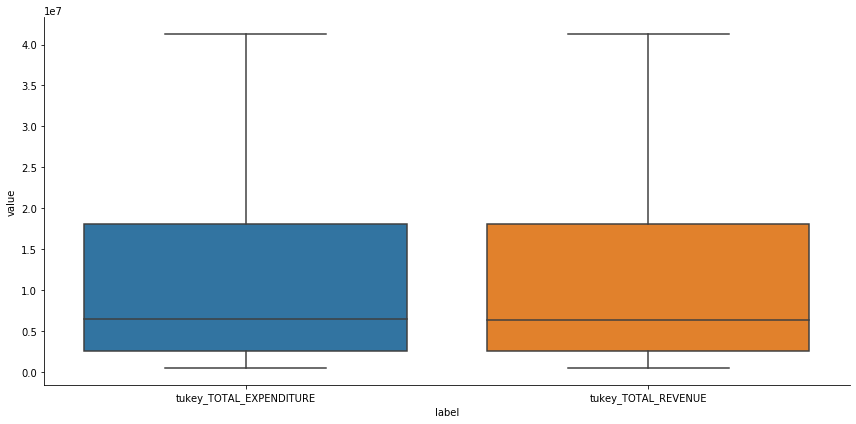

In [26]:
column_list = ['tukey_TOTAL_REVENUE', 'tukey_TOTAL_EXPENDITURE']
look_for_outliers(df_clean, column_list)

### Original - Using Winsor method

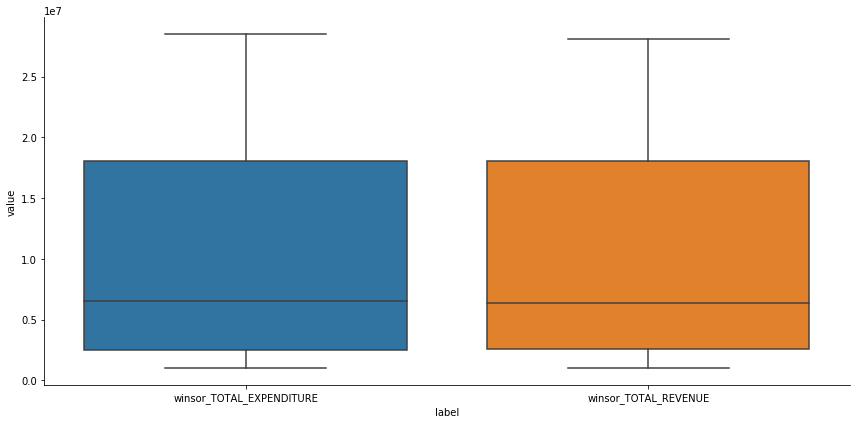

In [27]:
column_list = ['winsor_TOTAL_REVENUE', 'winsor_TOTAL_EXPENDITURE']
look_for_outliers(df_clean, column_list)

### Square-root - Using Tukey method

In [28]:
column_list = ['sqrt_TOTAL_REVENUE', 'sqrt_TOTAL_EXPENDITURE']
df_clean = correct_outliers(df_clean, column_list)

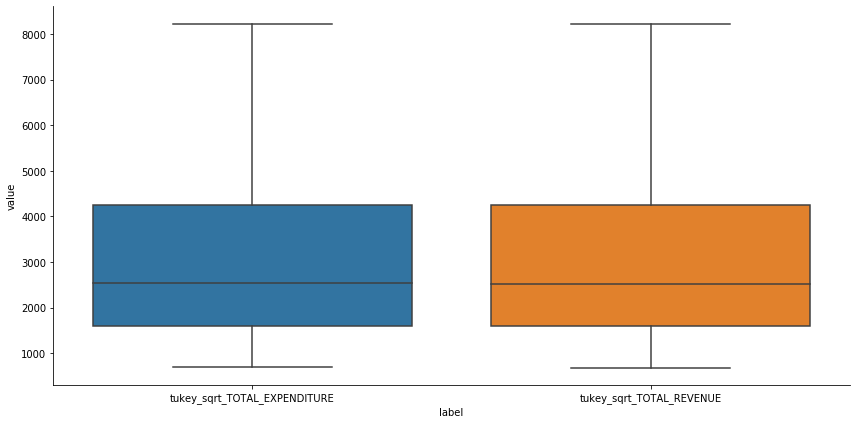

In [29]:
column_list = ['tukey_sqrt_TOTAL_REVENUE', 'tukey_sqrt_TOTAL_EXPENDITURE']
look_for_outliers(df_clean, column_list)

### Square-root - Using Winsor method

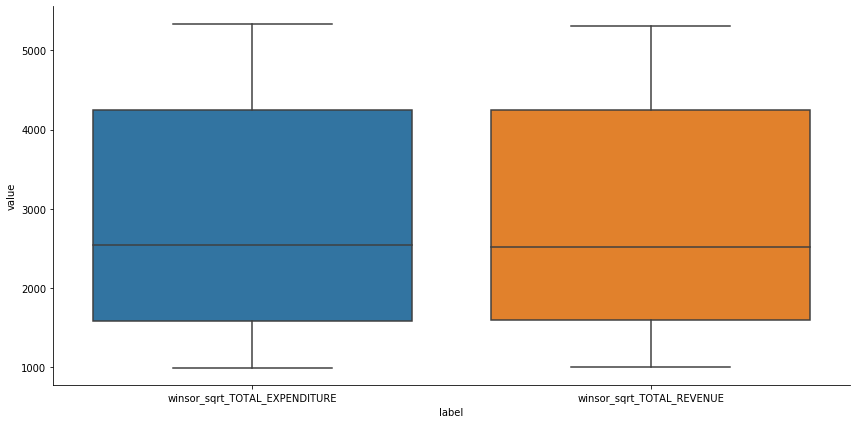

In [30]:
column_list = ['winsor_sqrt_TOTAL_REVENUE', 'winsor_sqrt_TOTAL_EXPENDITURE']
look_for_outliers(df_clean, column_list)

## Compute Budget Deficit

In [31]:
def compute_budget_deficit(df, column_1, column_2):
    
    new_column = 'BUDGET_DEFICIT'
    split_column = column_1.split('_')
    if len(split_column) > 2:
        new_column = f'{new_column}_{split_column[0].upper()}'
    df[new_column] = np.abs(df[column_1] - df[column_2])
    return df

### Use uncorrected values
Compute budget deficit using values that have not been corrected for outliers.

In [32]:
df_clean = compute_budget_deficit(df_clean, 'TOTAL_REVENUE', 'TOTAL_EXPENDITURE')

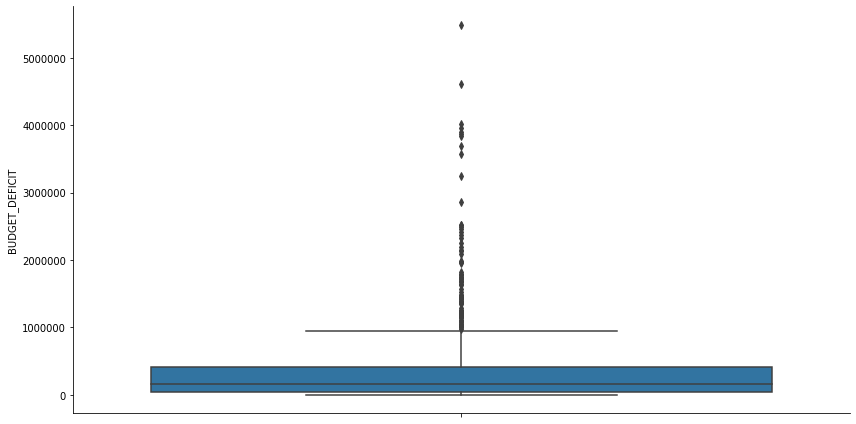

In [33]:
column_list = ['BUDGET_DEFICIT']
look_for_outliers(df_clean, column_list)

### Correct BUDGET_DEFICIT for outliers - Using Tukey method

In [34]:
column_list = ['BUDGET_DEFICIT']
thresholds['winsor_upper'] = 0.10
df_clean = correct_outliers(df_clean, column_list)

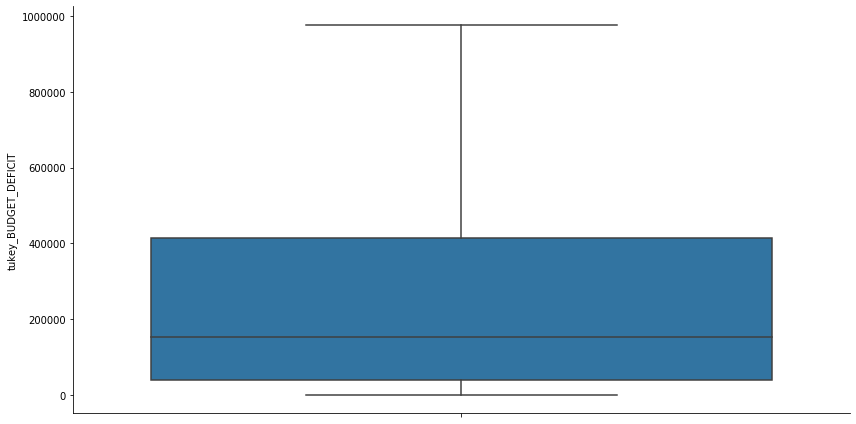

In [35]:
column_list = ['tukey_BUDGET_DEFICIT']
look_for_outliers(df_clean, column_list)

### Correct BUDGET_DEFICIT for outliers - Using Winsorize method

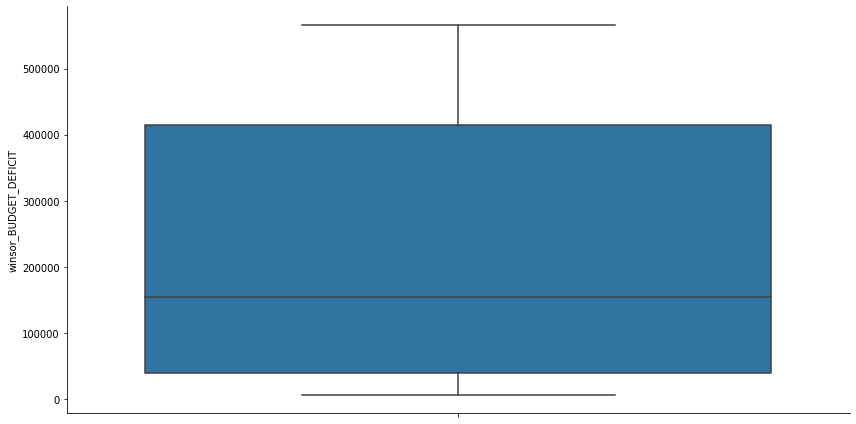

In [36]:
column_list = ['winsor_BUDGET_DEFICIT']
look_for_outliers(df_clean, column_list)

### Using corrected values
Compute budget deficit using values that have been corrected for outliers.
#### Winsor method

In [37]:
column_list = ['winsor_TOTAL_REVENUE', 'winsor_TOTAL_EXPENDITURE']
df_clean = compute_budget_deficit(df_clean, column_list[0], column_list[1])

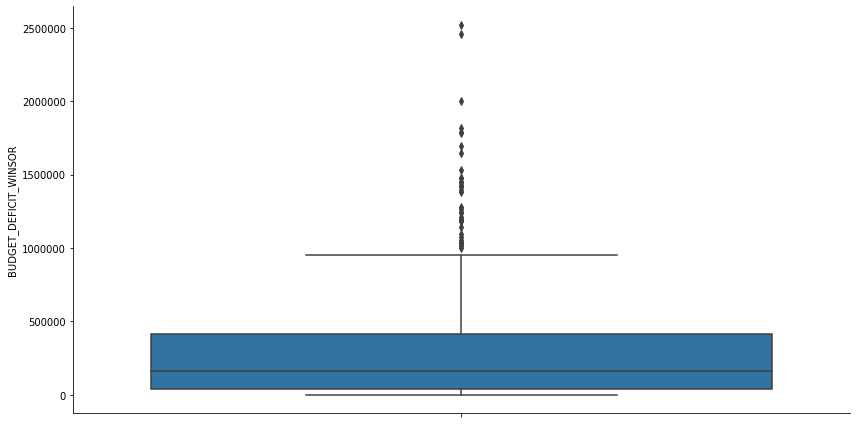

In [38]:
column_list = ['BUDGET_DEFICIT_WINSOR']
look_for_outliers(df_clean, column_list)

#### Correct for outliers

In [39]:
column_list = ['BUDGET_DEFICIT_WINSOR']
thresholds['winsor_upper'] = 0.05
df_clean = correct_outliers(df_clean, column_list)

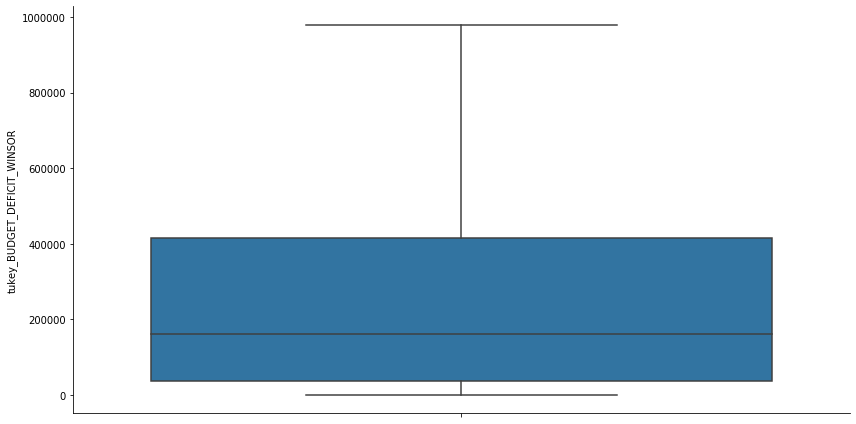

In [40]:
column_list = ['tukey_BUDGET_DEFICIT_WINSOR']
look_for_outliers(df_clean, column_list)

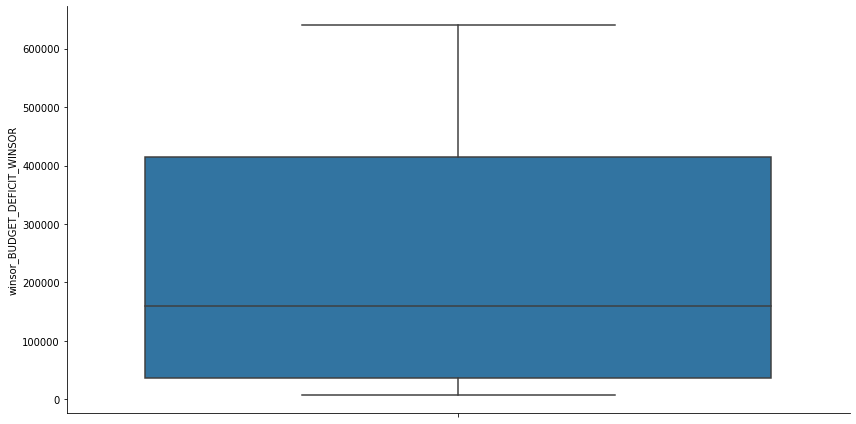

In [41]:
column_list = ['winsor_BUDGET_DEFICIT_WINSOR']
look_for_outliers(df_clean, column_list)

#### Tukey method

In [42]:
column_list = ['tukey_TOTAL_REVENUE', 'tukey_TOTAL_EXPENDITURE']
df_clean = compute_budget_deficit(df_clean, column_list[0], column_list[1])

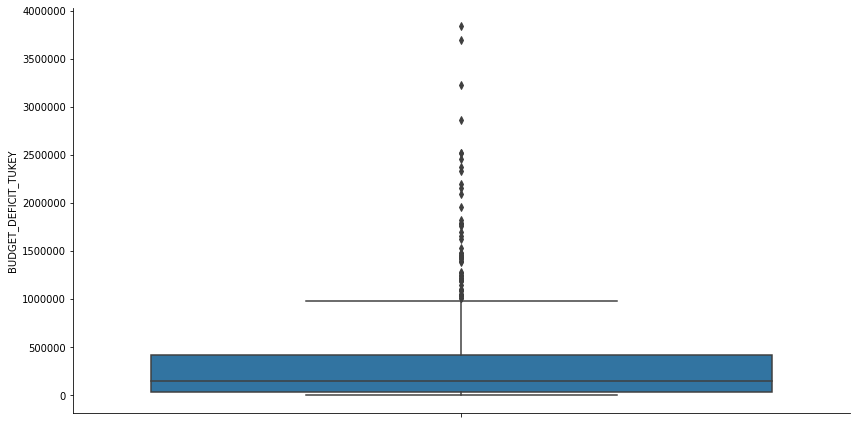

In [43]:
column_list = ['BUDGET_DEFICIT_TUKEY']
look_for_outliers(df_clean, column_list)

#### Correct for outliers

In [44]:
column_list = ['BUDGET_DEFICIT_TUKEY']
df_clean = correct_outliers(df_clean, column_list)

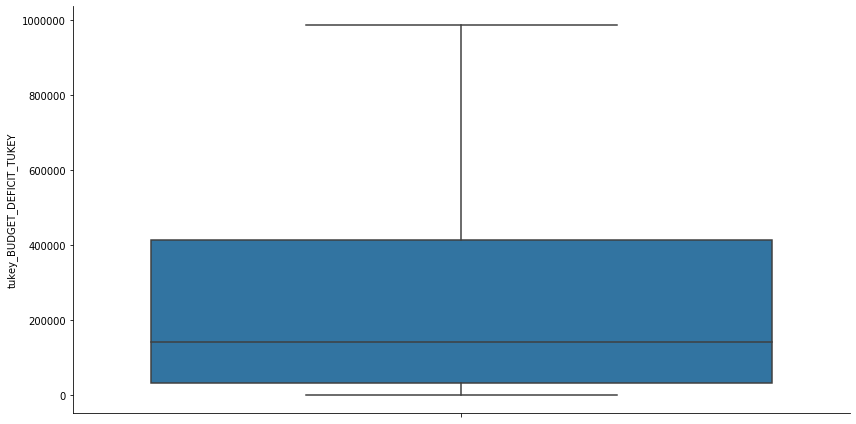

In [45]:
column_list = ['tukey_BUDGET_DEFICIT_TUKEY']
look_for_outliers(df_clean, column_list)

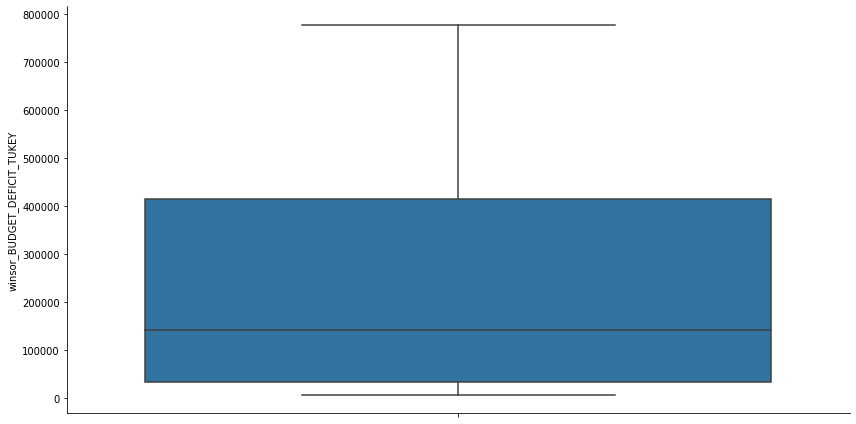

In [46]:
column_list = ['winsor_BUDGET_DEFICIT_TUKEY']
look_for_outliers(df_clean, column_list)

In [47]:
budget_columns = [column for column in df_clean.columns if 'BUDGET' in column]

In [48]:
df_clean.loc[:, budget_columns].describe().T.sort_values(by='max')

,count,mean,std,min,25%,50%,75%,max
winsor_BUDGET_DEFICIT,1492.0,220442.655831,193391.076034,6240.0,38820.75,153957.0,414013.0,566095.000
winsor_BUDGET_DEFICIT_WINSOR,1492.0,218234.572721,192526.502083,7852.0,37025.75,159878.0,414013.0,640608.000
winsor_BUDGET_DEFICIT_TUKEY,1492.0,219818.695962,216992.867716,6240.0,32469.00,140383.5,414013.0,777878.000
tukey_BUDGET_DEFICIT,1492.0,250177.928619,261367.936362,133.0,38820.75,153957.0,414013.0,976801.375
tukey_BUDGET_DEFICIT_WINSOR,1492.0,230078.180295,225294.864419,133.0,37025.75,159878.0,414013.0,979493.875
tukey_BUDGET_DEFICIT_TUKEY,1492.0,228156.895023,241326.856325,133.0,32469.00,140383.5,414013.0,986329.000
BUDGET_DEFICIT_WINSOR,1492.0,240388.478217,271525.141343,133.0,37025.75,159878.0,414013.0,2520706.000
BUDGET_DEFICIT_TUKEY,1492.0,251640.764075,353157.918840,133.0,32469.00,140383.5,414013.0,3837617.000
BUDGET_DEFICIT,1492.0,298087.472855,476007.895843,133.0,38820.75,153957.0,414013.0,5487742.000
